#### First run this then add run the main file
using this-: uvicorn app.main:app --reload

In [8]:
# from qdrant_client import QdrantClient
# q = QdrantClient(host="localhost", port=6333)
# q.delete_collection("agentforge_embeddings")

True

In [8]:
import requests
import json
import time
import pandas as pd

BASE_URL = "http://localhost:8000"


In [9]:
res = requests.get(f"{BASE_URL}/health/health")
print(res.status_code, res.json())


200 {'status': 'ok'}


# Multimodal Query (Image + PDF Text)

### image we are using is this 

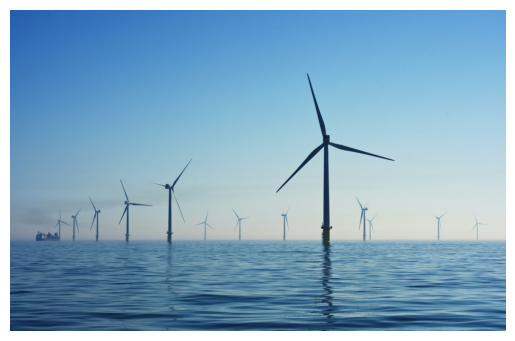

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('multimodal_examples/wind.jpeg')


plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
with open("multimodal_examples/Understanding_Modern_Wind_Turbine_Systems.pdf", "rb") as f:
    res = requests.post(
        f"{BASE_URL}/ingest/ingest",
        files={"file": ("Understanding_Modern_Wind_Turbine_Systems.pdf", f, "application/pdf")}
    )

print(res.json())


{'doc_id': '9c98b7ff-a62c-47f8-bdd7-8af131a369bc', 'type': 'text', 'chunks': 2, 'source': 'pdf → text (in memory)'}


In [13]:
with open("multimodal_examples/wind.jpeg", "rb") as f:
    res = requests.post(
        f"{BASE_URL}/multimodal/",
        files={"file": ("wind.jpeg", f, "image/jpg")},
        data={"query": "Based on the document and the image together, explain how wind turbines produce clean energy."}
    )

mm_output = res.json()
mm_output


{'final_answer': "Wind turbines convert wind energy into clean electricity through a straightforward process. The large blades of the turbine spin when wind passes through them, which turns a central shaft connected to a generator. This generator produces electricity that can power various needs, including homes and industries, without releasing any smoke or harmful gases. The image you see shows multiple wind turbines standing on the ocean's surface, capturing their collective impact on generating clean energy. In fact, modern wind farms like these often place several turbines together in areas with strong and steady winds, such as open fields, hilltops, or coastal regions. This not only increases but also makes the energy output more reliable. Each turbine is equipped with sensors that monitor its performance, including rotation speed, wind direction, weather conditions around the tower, and temperature levels inside the generator. These readings help engineers assess how well each t

# Langgraph Agent

In [ ]:
agent_tasks = [
    # "Summarize the story of Rohan from all ingested documents.",
    "Use reasoning to explain how wind turbines generate renewable energy based on the ingested PDF.",
    # "What skills did Rohan learn during his internships?",
    # "Plan steps for building a mini RAG system.",
    # "What were the achievements Rohan made at MBS Studio?",
    # "Given the wind turbine image and documents, explain the full workflow of clean energy generation."
]


In [11]:
def run_agent_test(task: str, engine: str):
    """
    Calls /agent endpoint with given engine (controller or langgraph)
    and records performance.
    """
    payload = {
        "task": task,
        "engine": engine
    }

    t0 = time.perf_counter()
    res = requests.post(f"{BASE_URL}/agent/", json=payload)
    t1 = time.perf_counter()

    if res.status_code != 200:
        return {
            "task": task,
            "engine": engine,
            "error": res.text,
            "latency_sec": round(t1 - t0, 4),
        }

    data = res.json()

    return {
        "task": task,
        "engine": engine,
        "final_answer":data["final_answer"],
        "answer_len": len(data["final_answer"].split()),
        "steps": len(data["steps"]),
        "latency_sec": round(t1 - t0, 4),
        "metrics": data["metrics"]
    }


In [12]:
records = []

for task in agent_tasks:
    print(f"\n--- Running: {task} ---")

    r1 = run_agent_test(task, "controller")
    r2 = run_agent_test(task, "langgraph")

    records.append(r1)
    records.append(r2)

df_agents = pd.DataFrame(records)
df_agents



--- Running: Use reasoning to explain how wind turbines generate renewable energy based on the ingested PDF. ---


,task,engine,final_answer,answer_len,steps,latency_sec,metrics
0,Use reasoning to explain how wind turbines gen...,controller,Here's a clear and concise explanation of how ...,168,1,64.8095,"{'tool_times': {'rag': 28.1113}, 'total_run_ti..."
1,Use reasoning to explain how wind turbines gen...,langgraph,Wind turbines generate renewable energy by con...,31,3,20.4967,"{'total_steps': 3, 'tools_used': ['rag'], 'too..."


In [13]:
df_agents[['task','engine','final_answer']]

,task,engine,final_answer
0,Use reasoning to explain how wind turbines gen...,controller,Here's a clear and concise explanation of how ...
1,Use reasoning to explain how wind turbines gen...,langgraph,Wind turbines generate renewable energy by con...


In [14]:
for _, row in df_agents.iterrows():
    print(f"[{row['engine']}] {row['task']}")
    print(row["final_answer"])
    print("=" * 90)


[controller] Use reasoning to explain how wind turbines generate renewable energy based on the ingested PDF.
Here's a clear and concise explanation of how wind turbines generate renewable energy: **Step 1: Wind hits the blades** The wind moves through the large blades of the turbine, causing them to spin around a central axis. **Step 2: Rotation generates electricity** As the blades rotate, they turn a connected shaft that is linked to a generator. This mechanical motion is converted into electrical energy by the generator. **Step 3: Electricity is produced** The generator produces clean electricity that can be used to power homes, schools, and industries. **Key Features** * Wind turbines use the natural force of wind to generate electricity. * The process does not release smoke or harmful gases, making it a renewable source of energy. * Modern wind farms place many turbines together to increase energy output and reliability. * Sensors inside each turbine track performance and alert ma